In [1]:
import numpy as np
import matplotlib.pylab as plt
%matplotlib notebook
import scipy.optimize as opt
import math
from scipy.integrate import ode

In [2]:
import pandas as pd

#load the data from the activation tutorial
SSA_data = pd.read_csv('Act_table.csv')
peaks = np.array((SSA_data.Peak_INa)/10)
tau = np.array(SSA_data.Tau_inact)
V_steps = np.array(SSA_data.Voltage)
#print(SSA_data)
#print(peaks)
#print(tau)
#print(V_steps)

In [3]:
def HH(y,t,V,P):
    #initialize output vector
    dy = np.zeros(2)
    
    # m-gate
    m = y[0]
    alpha_m = (P[0] + P[1]*V)/(1+P[2]*np.exp(P[3]*V))
    beta_m = P[4]*np.exp(P[5]*V)
    m_inf = alpha_m/(alpha_m+beta_m)
    
    # h-gate
    h = y[1]
    if type(V)==np.ndarray:
        alpha_h = 0*V
        idx = np.nonzero(V<-40)
        alpha_h = 0*V
        alpha_h[idx] = P[6]*np.exp(P[7]*V[idx])
        beta_h = (1.0/(P[8] + P[9]*np.exp(P[10]*V)));
        beta_h[idx] = P[11]*np.exp(0.35*V[idx]) + P[12]*np.exp(P[13]*V[idx])
    else:
        alpha_h = (0 if V >= -40 else P[6]*np.exp(P[7]*V))
        beta_h = (1.0/(P[8] + P[9]*np.exp(P[10]*V)) if V >= -40 else P[11]*np.exp(0.35*V) + P[12]*np.exp(P[13]*V))
        
    h_inf = alpha_h/(alpha_h+beta_h)
    
    dm = alpha_m*(1-m) - m*beta_m;
    dh = alpha_h*(1-h) - h*beta_h;
    
    dy[0] = dm
    dy[1] = dh
    
    return dy
    

<IPython.core.display.Javascript object>


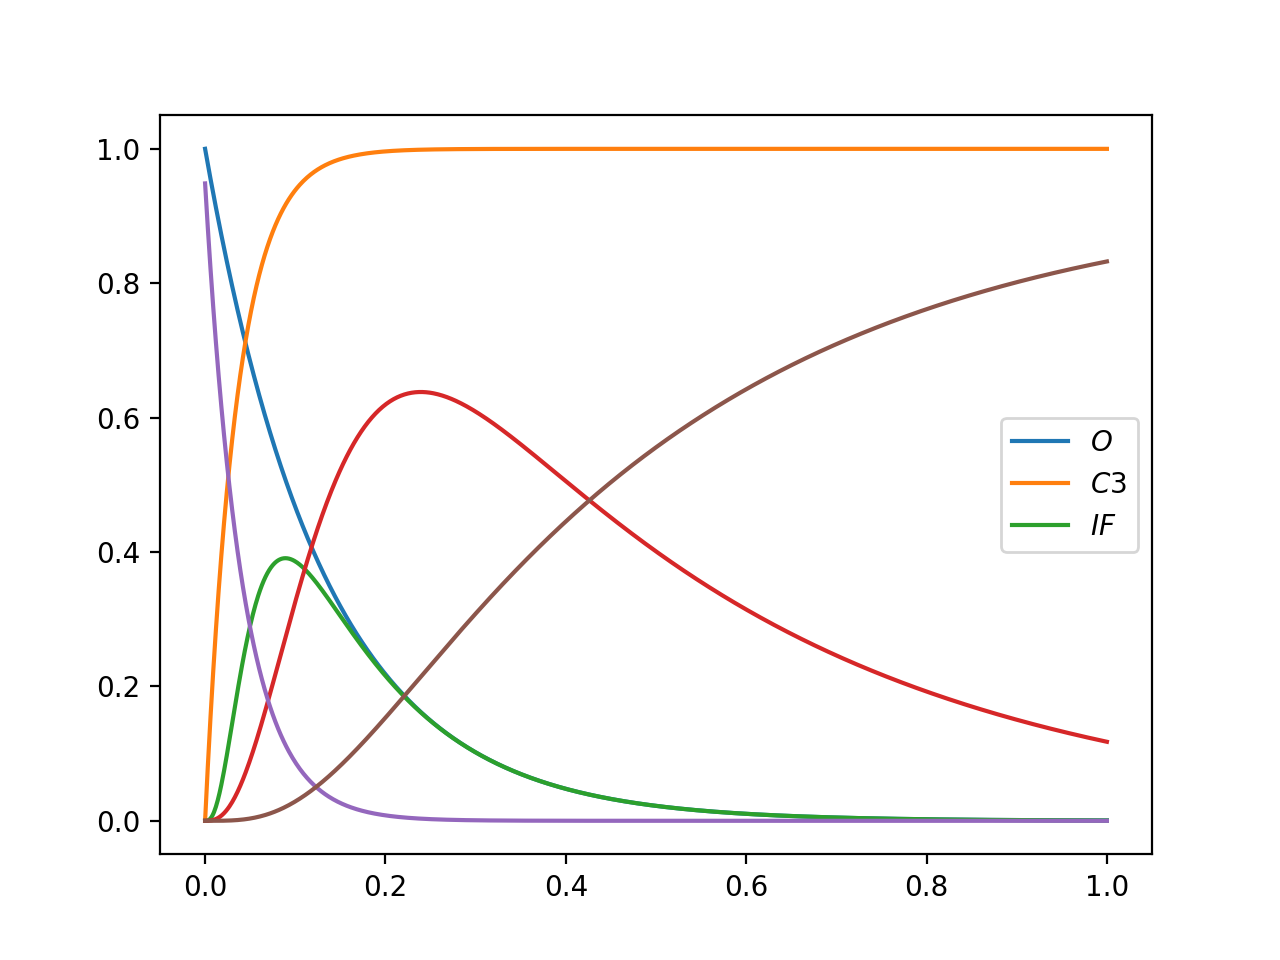

In [4]:
from scipy.integrate import odeint

HH_P = np.zeros((15))
HH_P[0] = 15.0816
HH_P[1] = 0.32
HH_P[2] = -0.0089778037307
HH_P[3] = -0.1
HH_P[4] = 0.08
HH_P[5] = -0.0909090909091
HH_P[6] = 1.04951082543e-06
HH_P[7] = -0.147058823529
HH_P[8] = 0.13
HH_P[9] = 0.0497581410839
HH_P[10] = -0.0900900900901
HH_P[11] = 310000.0
HH_P[12] = 3.56
HH_P[13] = 0.079
HH_P[14] = 10

t = np.linspace(0,1,1001)
y0 = [0,1]
V_hold = 40 
y = odeint(HH, y0, t, (V_hold,HH_P))
m = y[:,0]
h = y[:,1]
plt.plot(t,h,t,m,t,pow(m,3)*h); plt.legend((r'$h$',r'$m$',r'$m^3*h$')); plt.show()

In [5]:
def Markov_Na_Matrix(V,P):
    
    # A Markov state model for the fast sodium current (INa)
    # Grandi et al. 2007
    
    # state indices for mass matrix
    O = int(0)
    IF = int(1)
    IM1 = int(2)
    IM2 = int(3)
    C3 = int(4)
    C2 = int(5)
    C1 = int(6)
    IC3 = int(7)
    IC2 = int(8)
  
    n = 9 # number of states
    A = np.zeros((n,n)) # initialize rate mass matrix for output
    
    alpha1 = P[0]/(P[1]*math.exp(-(V+P[2])/P[3])+ P[6]*math.exp(-(V+P[2])/150));
    alpha2 = P[0]/(P[1]*math.exp(-(V+P[2])/P[4])+ P[7]*math.exp(-(V+P[2])/150));
    alpha3 = P[0]/(P[1]*math.exp(-(V+P[2])/P[5])+ P[8]*math.exp(-(V+P[2])/150));
    beta1 = P[9]*math.exp(-(V+P[2])/P[10]);
    beta2 = P[11]*math.exp(-(V-P[12])/P[10]);
    beta3 = P[13]*math.exp(-(V-P[14])/P[10]);
    alpha4 = 1/(P[15]*math.exp(-(V+7)/P[16])+P[17]);
    alpha5 = P[18]*math.exp(-(V+7)/P[19]);
    beta5 = P[20] + P[21]*(V+7);
    beta4 = (alpha3*alpha4*alpha5)/(beta3*beta5);
    alpha6 = alpha4/P[22];
    beta6 = P[23]*math.exp(-V/P[24]);
    alpha7 = P[25]*math.exp(V/P[26]);
    beta7 = P[28]*math.exp(-V/P[29]);
    #alpha8 = P[30];
    #beta8 = P[31];
    
    #Assign transitions
    A[C3, C2] = beta1
    A[C2, C3] = alpha1
    A[C2, C1] = beta2
    A[C1, C2] = alpha2
    A[C1, O]  = beta3
    A[O, C1]  = alpha3
    A[O, IF]  = beta4
    A[IF,O] = alpha4
    A[IF,C1] = beta5
    A[C1,IF] = alpha5
    A[IC2,C2] = beta5
    A[C2,IC2] = alpha5
    A[IC3,C3] = beta5
    A[C3,IC3] = alpha5
    A[IF,IM1] = beta6
    A[IM1,IF] = alpha6
    A[IM1,IM2] = beta7
    A[IM2,IM1] = alpha7    
    
    for i in range(n):
        A[i,i] = -math.fsum(A[:,i])
    
    return A

In [6]:
import numpy.linalg as lin
def Markov_Na_Init(V,P):
    b = np.zeros(9)
    A = Markov_Na_Matrix(P,V)
    A[-1,:] = 1;
    b[-1] = 1
    
    return lin.solve(A,b)

In [7]:
def Markov_Na(y,t,V,P):
    # Initialize the output vector
    dim = y.shape
    dy = np.zeros((dim))
    A = Markov_Na_Matrix(V,P)
    
    dy = A.dot(y)
    return dy

In [8]:
from scipy.integrate import odeint

#Na Channel parameter set 
P1 = np.zeros((31))
P1[0] = 3.802; P1[1] = 0.1027;P1[2] = 2.5;P1[3] = 17;P1[4] = 15;P1[5] = 12;P1[6] = 0.2;P1[7] = 0.23;P1[8] = 0.25;
P1[9] = 0.1917; P1[10] = 20.3;
P1[11] = 0.2; P1[12] = 2.5;
P1[13] = 0.22; P1[14] = 7.5;
P1[15] = 0.188495; P1[16] = 16.6; P1[17] = 0.393956;
P1[18] = 7e-07; P1[19] = 7.2; 
P1[20] = 0.0084/1.9; P1[21] = 2e-05; 
P1[22] = 100; 
P1[23] = 8.9554e-07; P1[24] = 11.3944; 
P1[25] = 4.8696e-05; P1[26] = 23.2696; 
P1[28] = 2.868e-04; P1[29] = 35.9898;
P1[30] = 7
#P1[30] = 1e-08/1000;
#P1[31] = 9.8e-03/1000;

V_init = -90   
y0 = Markov_Na_Init(P1,V_init)

#print (y0)
    
t = np.linspace(0,1,1001) 
V_hold = 40 
y = odeint(Markov_Na, y0, t, (V_hold, P1))

O = y[:,0]
IF = y[:,1]
IM1 = y[:,2]
IM2 = y[:,3]
C3 = y[:,4]
C2 = y[:,5]
C1 = y[:,6]
IC3 = y[:,7]
IC2 = y[:,8]

plt.plot(t,O,t,C3,t,IF); plt.legend((r'$O$',r'$C3$',r'$IF$')); plt.show()

In [9]:
def Activation(P,V,model):
    
    # Make a more realistic I_Na current, where the conductance is voltage depedendet
    R = 8314 # mJ/(K mol)
    T = 273.0+37.0 #  K
    F = 96485.33289 # C/mol 
    Na_o = 140.0
    Na_i = 10.0;
    E_Na = (R*T/F)*math.log(Na_o/Na_i) # mV
    
    #configure activation protocol
    step_duration = 1000
    ntsteps = int(step_duration*100)
    
    #initialize outputs
    Po_out = np.zeros((ntsteps,len(V)))
    model_I = np.zeros((ntsteps,len(V)))
    model_peaks = np.zeros((len(V)))
    
    #step through the test potentials in your reference data
    for idx,i in enumerate(V): 
        V_hold = -90
        if model == 1: # Markov model
            # First reset your initial conditions to the holding potential at the beginning of each step
            # Question: Is this always a good idea? Why or why not?
            y0 = Markov_Na_Init(P,V_hold)
            # Run the model
            t = np.linspace(0,10,100000) 
            y = odeint(Markov_Na, y0, t, (V[idx], P1))
            #store the open probability data and calculate the error metrics
            Po_out[:,idx] = y[:,0]
            model_I[:,idx] = P1[-1]*Po_out[:,idx]*(V[idx]-E_Na)
            model_peaks[idx] = model_I[:,idx].min()
            out = {'t':t, 'Po':Po_out,'I':model_I,'I_peak':model_peaks}
        else:
            y0 = [0,1] # More simple initialization 
            t = np.linspace(0,10,100000) 
            y = odeint(HH, y0, t, (V[idx], P))
            #store the open probability data and calculate the error metrics
            m = y[:,0]
            h = y[:,1] 
            Po_out[:,idx] = pow(m,3)*h   
            model_I[:,idx] = HH_P[-1]*Po_out[:,idx]*(V[idx]-E_Na)
            model_peaks[idx] = model_I[:,idx].min()
            out = {'t':t, 'Po':Po_out,'I':model_I,'I_peak':model_peaks}
      
    return out



In [10]:
HH_dats = Activation(HH_P,V_steps,0)
HH_I_peaks = HH_dats['I_peak']
HH_I = HH_dats['I']
HH_Po = HH_dats['Po']
HH_t = HH_dats['t']

Markov_dats = Activation(P1,V_steps,1)
Markov_I_peaks = Markov_dats['I_peak']
Markov_I = Markov_dats['I']
Markov_Po = Markov_dats['Po']
Markov_t = Markov_dats['t']
#print (t)
#print (Po)
#print (model_I)
    

<IPython.core.display.Javascript object>


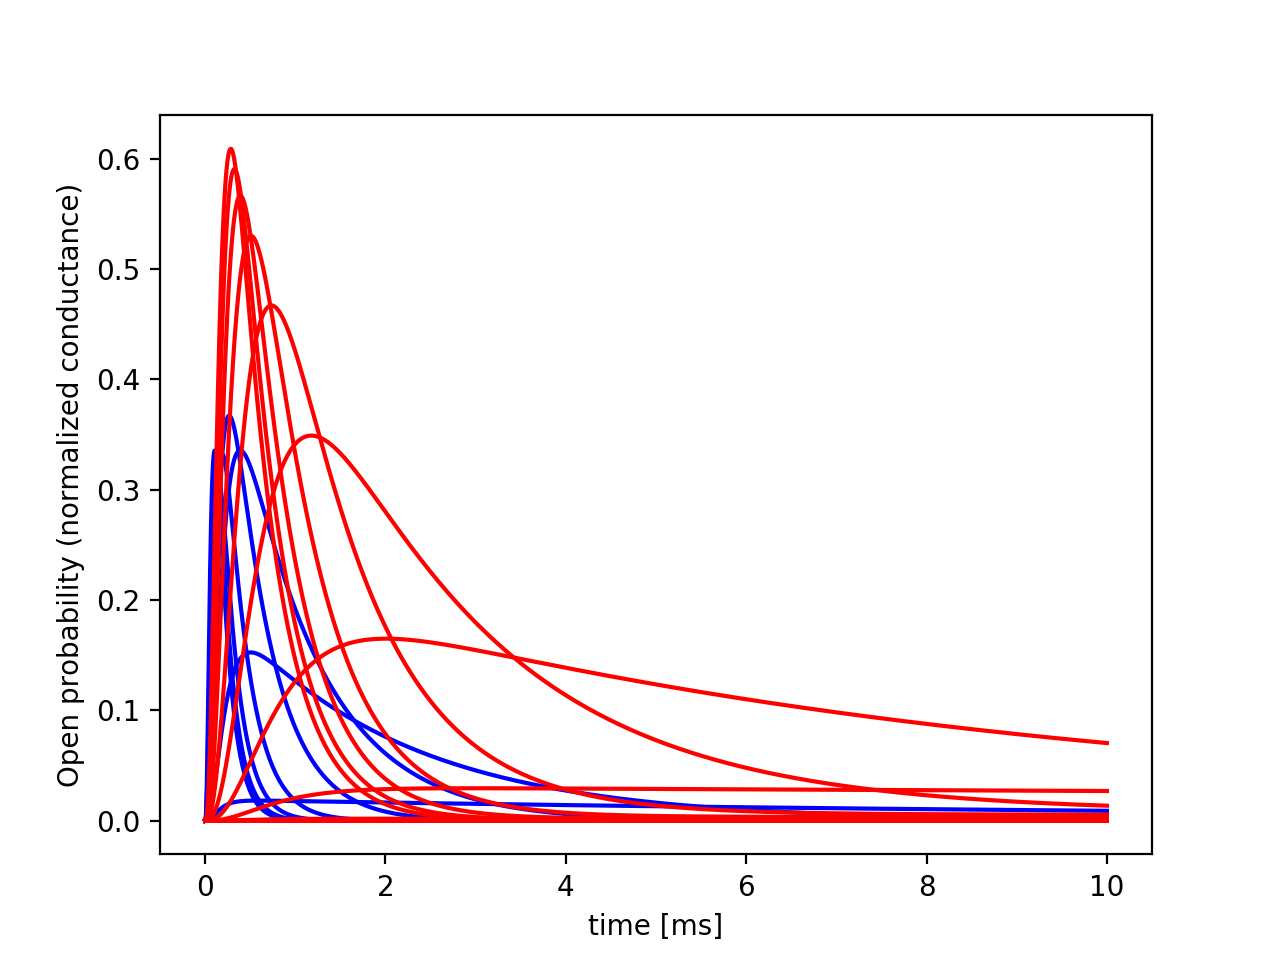

In [11]:
plt.figure()
plt.plot(HH_t,HH_Po,'b')
plt.plot(Markov_t,Markov_Po,'r')
plt.xlabel('time [ms]')
plt.ylabel('Open probability (normalized conductance)')

<IPython.core.display.Javascript object>


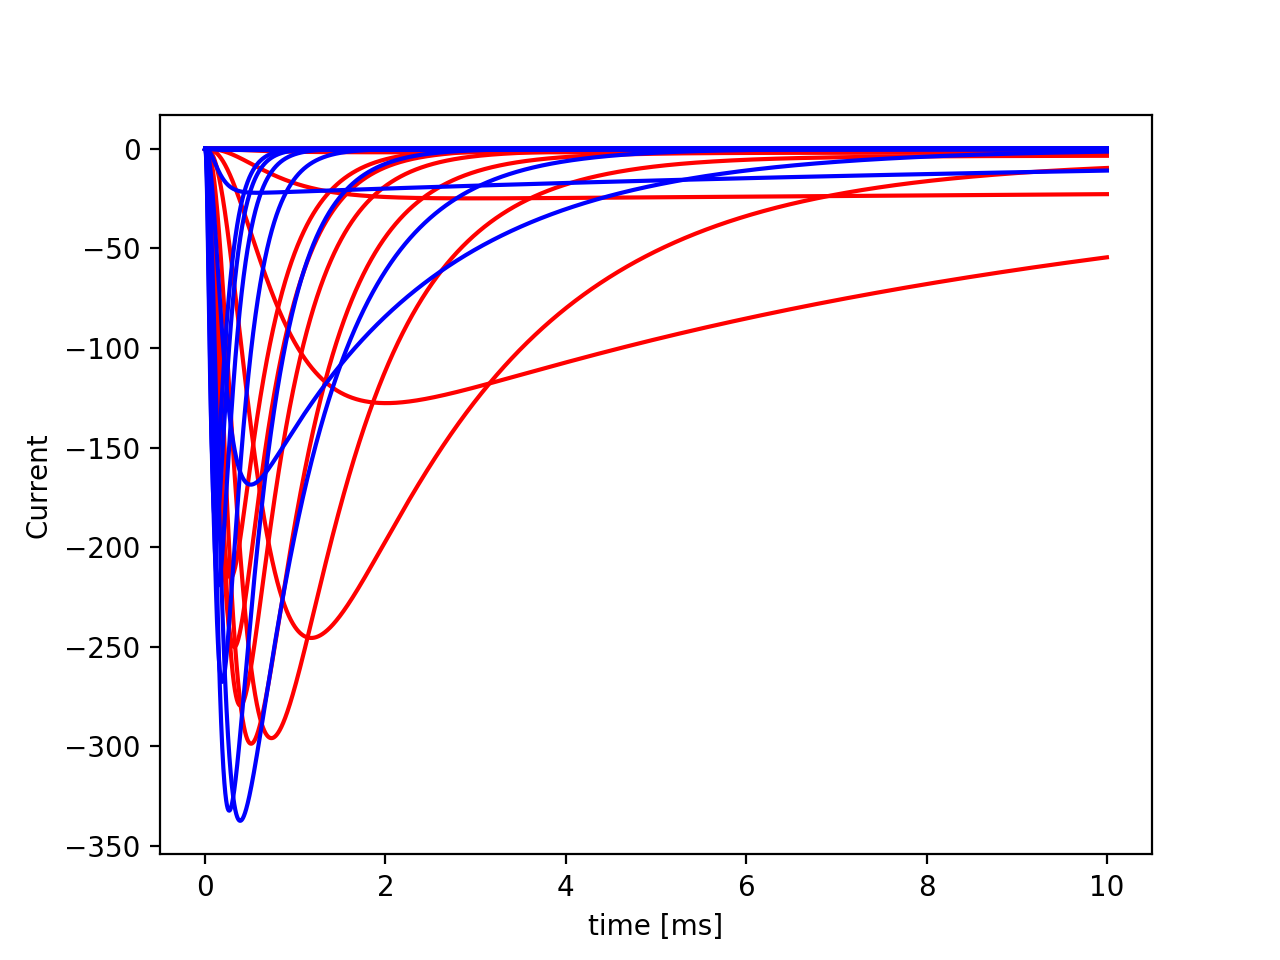

In [12]:
plt.figure()
plt.plot(Markov_t,Markov_I,'r')
plt.plot(HH_t,HH_I,'b')
plt.xlabel('time [ms]')
plt.ylabel('Current')

<IPython.core.display.Javascript object>


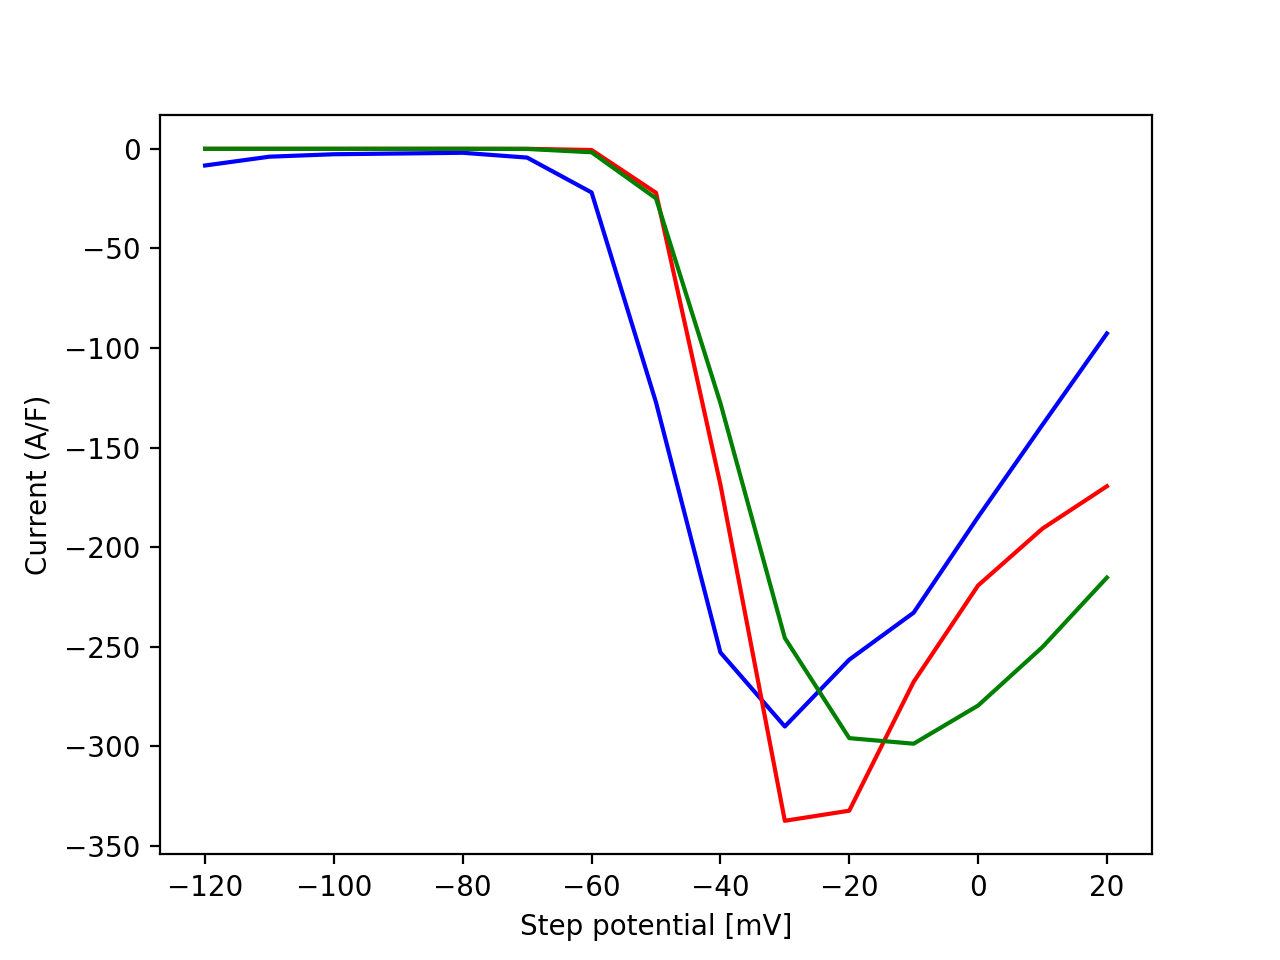

In [13]:
plt.figure()
plt.plot(V_steps,peaks,'b-')
plt.plot(V_steps,HH_I_peaks,'r-')
plt.plot(V_steps,Markov_I_peaks,'g-')
plt.xlabel('Step potential [mV]')
plt.ylabel('Current (A/F)')

In [14]:
def cost(P,V,peaks,model):
    
    outs = Activation(P,V,model)
    model_peaks = outs['I_peak']
       
    dev_vector = model_peaks - peaks
    error = np.linalg.norm(dev_vector,2)
        
    return error

In [ ]:
model = 1
[P_opt, f_opt, iters, funcalls, warnflag] = opt.fmin(cost, P1, args=(V_steps,peaks,model),
                                                    maxiter = 10000, maxfun = 20000, full_output=True, disp=True)

In [ ]:
print(P_opt)
print(P1)

print(cost(P_opt,V_steps,peaks,model))
print(cost(P1,V_steps,peaks,model))


In [ ]:
plt.figure()
trial = Activation(P_opt,V_steps,model)
plt.plot(V_steps,peaks,'b-')
plt.plot(V_steps,trial['I_peak'],'r-')